In [274]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_score

In [275]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')

In [276]:
train = pd.read_csv('data/train.csv', parse_dates=['datetime'])
test = pd.read_csv('data/test.csv', parse_dates=['datetime'])
sub=pd.read_csv('data/sampleSubmission.csv')

### 날짜 데이터 추가

In [277]:
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["day"] = train["datetime"].dt.day
train["hour"] = train["datetime"].dt.hour 
train["weekday"] = train["datetime"].dt.weekday
train['logcount'] = np.log1p(train['count'] )

In [278]:
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["day"] = test["datetime"].dt.day
test["hour"] = test["datetime"].dt.hour 
test["weekday"] = test["datetime"].dt.weekday

### cost function 
https://www.slideshare.net/KhorSoonHin/rmsle-cost-function

In [255]:
def rmsle(predicted_values, actual_values, convertExp=True):

    if convertExp:
        predicted_values = np.exp(predicted_values)-1
        actual_values = np.exp(actual_values)-1

    # 넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)

    # 예측값과 실제 값에 1을 더하고 로그를 씌워준다.
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)

    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = (log_predict - log_actual)**2 

    # 평균을 낸다.
    mean_difference = np.average(difference)

    # 다시 루트를 씌운다.
    score = np.sqrt(mean_difference)

    return score

### 성능평가

In [256]:
def cross_validation(num, model, X, y):
    cv = KFold(num) 
    scores = np.zeros(num)
 
    X = np.array(X)
    y = np.array(y)
    for i, (train_index, test_index) in enumerate(cv.split(X)):
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        
        
        model.fit(X_train, y_train)
        
        preds = model.predict(X_test)
        scores[i] = rmsle(preds, y_test)
    
    return scores

In [279]:
feature_names = ["season", "weather", "temp", "atemp", "humidity",
                 "year", "hour", "weekday", "holiday", "workingday"]
#label_name = "count"
label_name = 'logcount'

In [280]:
y_train = train[label_name]
X_train = train[feature_names]
X_test = test[feature_names]

### Linear Regression Model

In [260]:
# 선형회귀 모델을 초기화
lModel = LinearRegression()

# 모델을 학습시킨다. 
lModel.fit(X_train, y_train)

# 예측하고 정확도를 평가한다.
preds = lModel.predict(X_train)
print ("RMSLE Value For Linear Regression: ",rmsle(y_train, preds))

RMSLE Value For Linear Regression:  1.0183344146540012


In [261]:
model = LinearRegression()
cross_validation(5, model, X, y)

array([1.0680099 , 0.96980703, 1.06401539, 1.1570627 , 1.1133796 ])

---

### 릿지 Regularization Model - Ridge

{'alpha': 0.01, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  1.0183344146543412


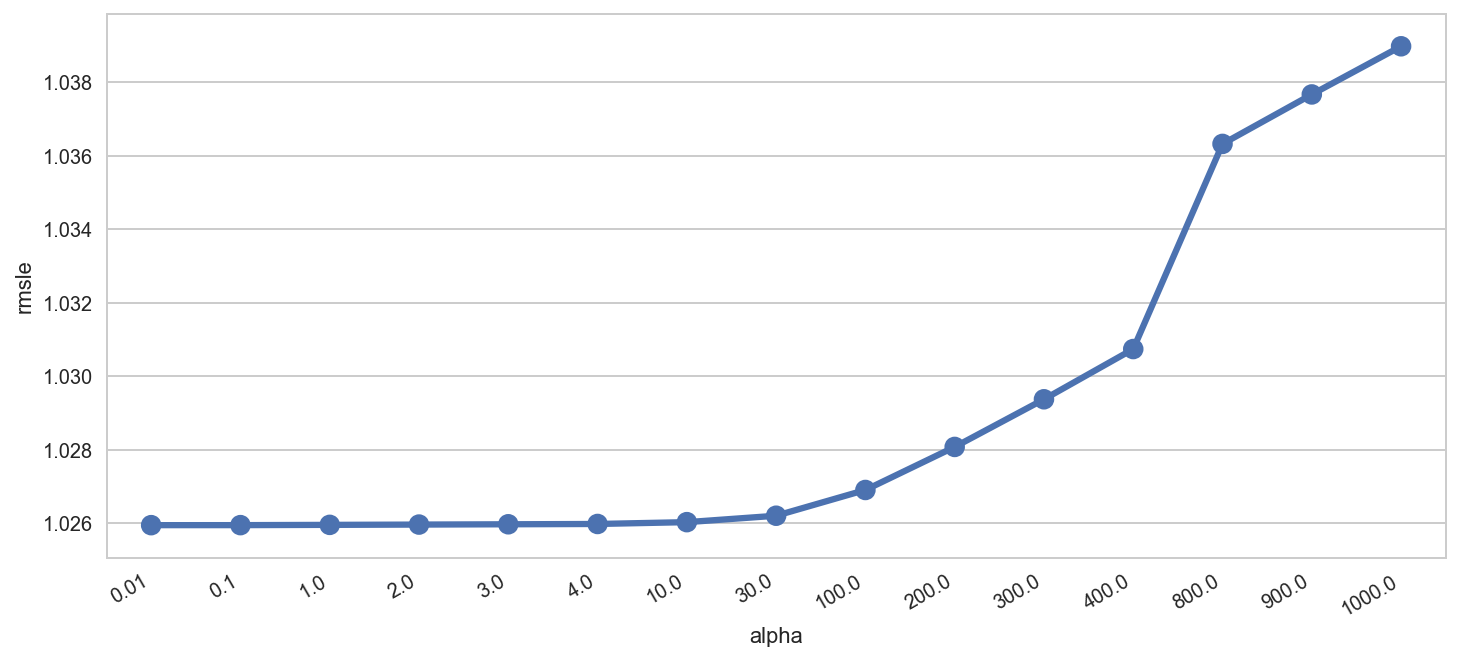

In [262]:
ridge_m_ = Ridge()
ridge_params_ = { 'max_iter':[3000],'alpha':[0.01, 0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_ridge_m = GridSearchCV( ridge_m_,
                          ridge_params_,
                          scoring = rmsle_scorer,
                          cv=5)
 
grid_ridge_m.fit( X_train, y_train )
preds = grid_ridge_m.predict(X_train)
print (grid_ridge_m.best_params_)
print ("RMSLE Value For Ridge Regression: ", rmsle(y_train, preds))

fig,ax= plt.subplots()
fig.set_size_inches(12,5)
df = pd.DataFrame(grid_ridge_m.grid_scores_)
df["alpha"] = df["parameters"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_validation_score"].apply(lambda x:-x)

plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df,x="alpha",y="rmsle",ax=ax)
plt.show()

### 라쏘 Regularization Model - Lasso

{'alpha': 0.001, 'max_iter': 3000}
RMSLE Value For Lasso Regression:  1.0183472255315384


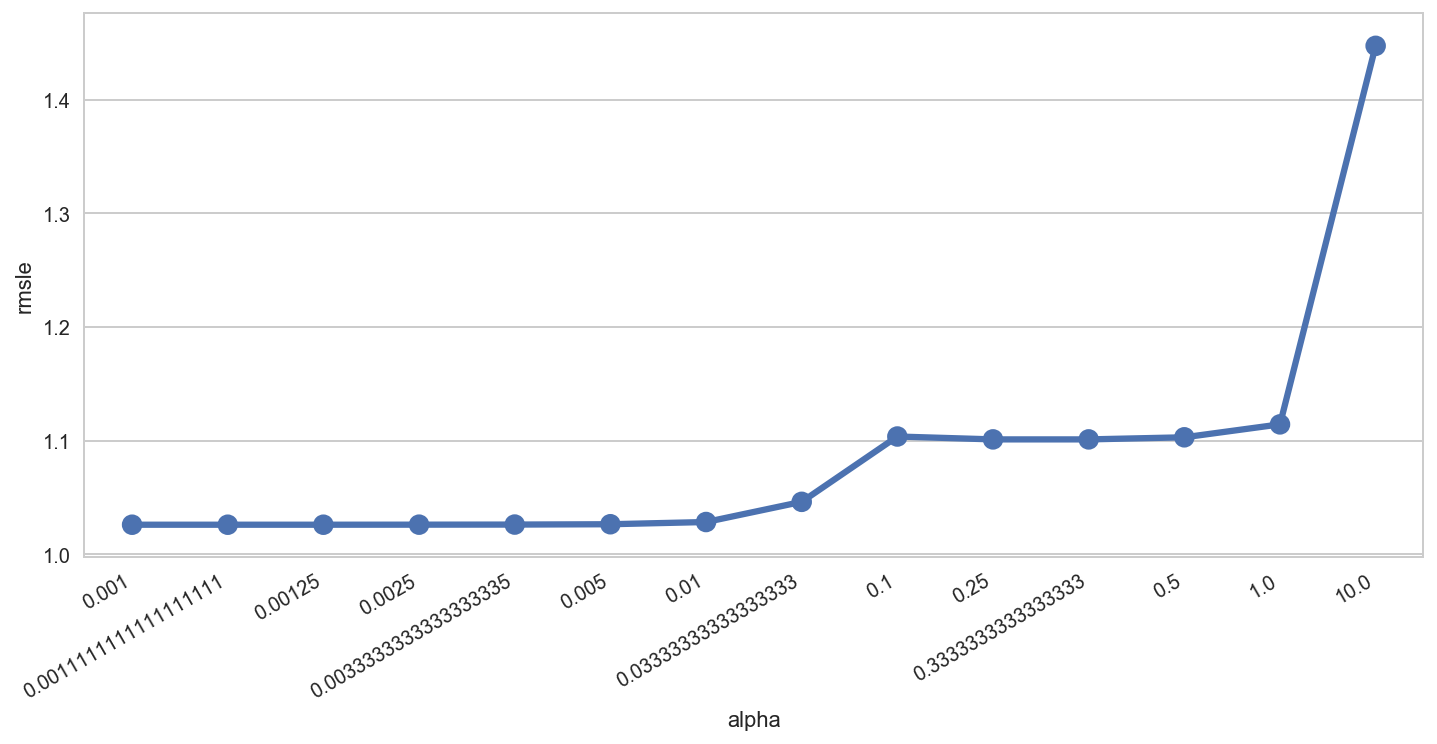

In [263]:
lasso_m_ = Lasso()

alpha  = 1/np.array([0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000])
lasso_params_ = { 'max_iter':[3000],'alpha':alpha}

grid_lasso_m = GridSearchCV( lasso_m_,lasso_params_,
                            scoring = rmsle_scorer, cv=5)
 
grid_lasso_m.fit( X_train , y_train )
preds = grid_lasso_m.predict(X_train)
print (grid_lasso_m.best_params_)
print ("RMSLE Value For Lasso Regression: ",rmsle(y_train, preds))

fig,ax= plt.subplots()
fig.set_size_inches(12,5)
df = pd.DataFrame(grid_lasso_m.grid_scores_)
df["alpha"] = df["parameters"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_validation_score"].apply(lambda x:-x)

plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df,x="alpha",y="rmsle",ax=ax)
plt.show()

---

### RandomForestRegressor

In [264]:
rfModel = RandomForestRegressor(n_estimators=100)

rfModel.fit(X_train, y_train)

preds = rfModel.predict(X_train)
score = rmsle(y_train, preds)
print ("RMSLE Value For Random Forest: ",score)

RMSLE Value For Random Forest:  0.1150449650073318


In [265]:
cross_validation(5, rfModel, X_train, y_train)

array([0.69617162, 0.38493793, 0.50718231, 0.33949812, 0.38877153])

---

### GradientBoostingRegressor

In [247]:
gbm = GradientBoostingRegressor(n_estimators=4000, alpha=0.01);

gbm.fit(X_train, y_train)

preds = gbm.predict(X_train)
score = rmsle(y_train, preds)
print ("RMSLE Value For Gradient Boost: ", score)

RMSLE Value For Gradient Boost:  0.22782233696540652


In [266]:
cross_validation(5, gbm, X_train, y_train)

array([0.64669913, 0.32899551, 0.40061467, 0.32147374, 0.38783172])

---

### ExtraTreesRegressor

In [267]:
xrfModel = ExtraTreesRegressor(n_estimators=100)
xrfModel.fit(X_train, y_train)

preds = xrfModel.predict(X_train)
score = rmsle(y_train, preds)
print ("RMSLE Value For ExtraTreesRegressor: ",score)

RMSLE Value For ExtraTreesRegressor:  0.019362766556961942


In [268]:
cross_validation(5, xrfModel, X_train, y_train)

array([0.70509285, 0.36733163, 0.45720271, 0.3283055 , 0.35425743])

---

### XGBRegressor

In [287]:
xgb = XGBRegressor(n_estimators=500, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
xgb.fit(X_train, y_train)
preds = xgb.predict(X_train)
score = rmsle(y_train, preds)
print ("RMSLE Value For XGBoost: ", score)

RMSLE Value For XGBoost:  0.11810094361712775


In [282]:
cross_validation(5, xgb, X_train, y_train)

array([0.65299062, 0.32832999, 0.41981245, 0.331301  , 0.35923503])

---

### submission 

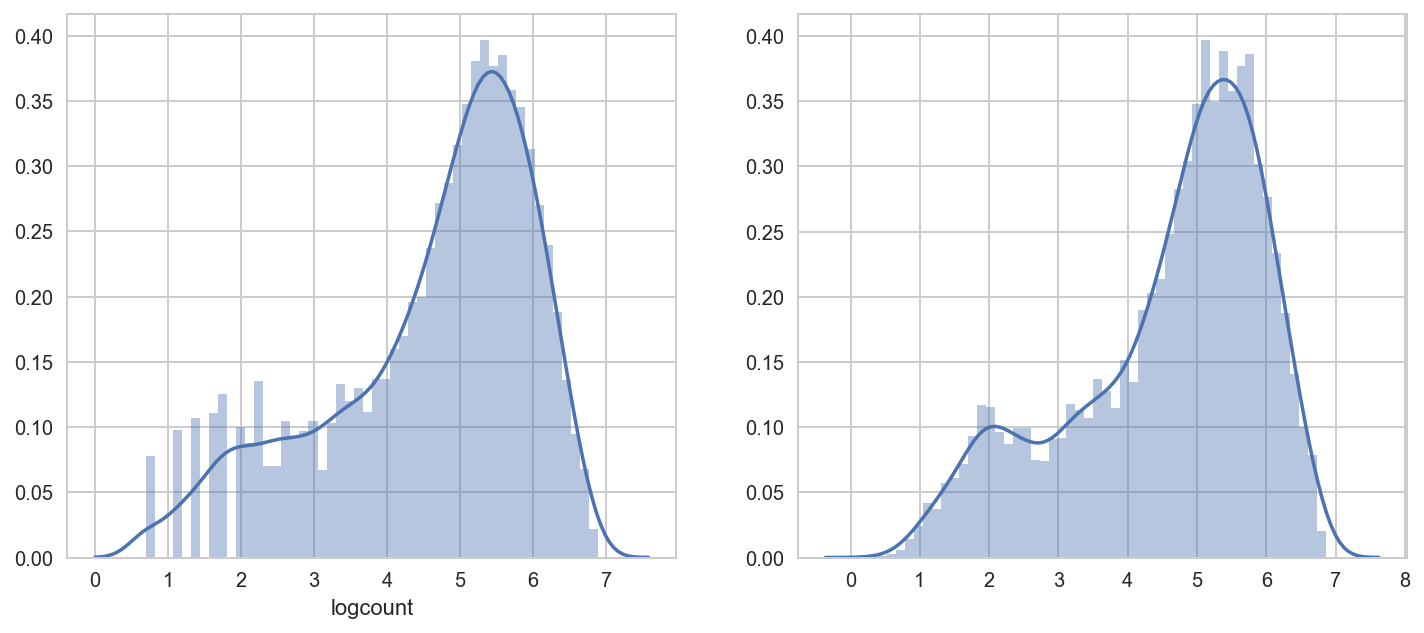

In [288]:
predsTest = xgb.predict(X_test)

fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
sns.distplot(predsTest,ax=ax2,bins=50)

In [290]:
sub["count"] = np.exp(predsTest)-1
sub.to_csv('data/report.csv', index=False)

XGBoost - 0.39684 (201/3251) 상위 6%

In [315]:
from fbprophet import Prophet

### 시계열 분석

In [447]:
test['casual'] = np.nan
test['registered'] = np.nan
test['count'] = np.nan
test['logcount'] = np.nan

In [463]:
merged = pd.concat([train, test])
merged = merged.sort_values(by=['datetime']).reset_index(drop=True)
holidays = merged[merged.workingday == 0]['datetime'].values

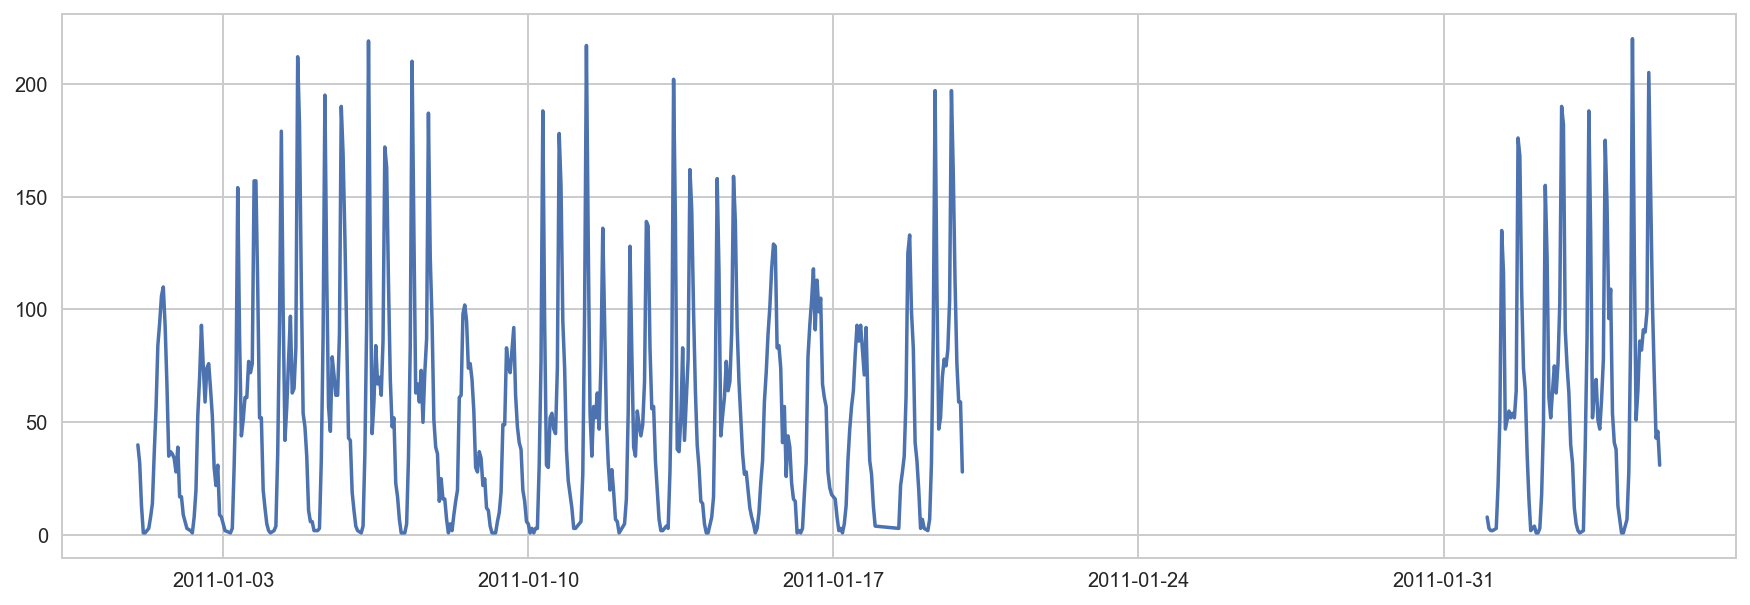

In [490]:
plt.figure(figsize=(15, 5))
df_2011_1 = merged[(merged.datetime < '2011-02-5') & (merged.datetime > '2011-01-1')]
plt.plot(df_2011_1.datetime, df_2011_1['count']) 

# df_2011_1 = merged[(merged.datetime < '2012-02-1') & (merged.datetime > '2012-01-1')]
# plt.plot(list(range(len(df_2011_1))), df_2011_1['count']) 

In [467]:
merged

,atemp,casual,count,datetime,day,holiday,hour,humidity,logcount,month,registered,season,temp,weather,weekday,windspeed,workingday,year
0,14.395,3.0,16.0,2011-01-01 00:00:00,1,0,0,81,2.833213,1,13.0,1,9.84,1,5,0.0000,0,2011
1,13.635,8.0,40.0,2011-01-01 01:00:00,1,0,1,80,3.713572,1,32.0,1,9.02,1,5,0.0000,0,2011
2,13.635,5.0,32.0,2011-01-01 02:00:00,1,0,2,80,3.496508,1,27.0,1,9.02,1,5,0.0000,0,2011
3,14.395,3.0,13.0,2011-01-01 03:00:00,1,0,3,75,2.639057,1,10.0,1,9.84,1,5,0.0000,0,2011
4,14.395,0.0,1.0,2011-01-01 04:00:00,1,0,4,75,0.693147,1,1.0,1,9.84,1,5,0.0000,0,2011
5,12.880,0.0,1.0,2011-01-01 05:00:00,1,0,5,75,0.693147,1,1.0,1,9.84,2,5,6.0032,0,2011
6,13.635,2.0,2.0,2011-01-01 06:00:00,1,0,6,80,1.098612,1,0.0,1,9.02,1,5,0.0000,0,2011
7,12.880,1.0,3.0,2011-01-01 07:00:00,1,0,7,86,1.386294,1,2.0,1,8.20,1,5,0.0000,0,2011
8,14.395,1.0,8.0,2011-01-01 08:00:00,1,0,8,75,2.197225,1,7.0,1,9.84,1,5,0.0000,0,2011
9,17.425,8.0,14.0,2011-01-01 09:00:00,1,0,9,76,2.708050,1,6.0,1,13.12,1,5,0.0000,0,2011
